# MonetGAN
#### Submission for Intro to Deep Learning Coursera 

### Problem Statement
For this Kaggle Competition the task is to perform image translation of photos to monetesque painting using Generative Adversarial Networks. [Link to competition page](https://www.kaggle.com/competitions/gan-getting-started/overview). Details of the dataset can be found in the EDA section.

### Github Repository
https://github.com/jagrat89/MonetGAN

### References 
I have followed these two tutorials for creating this notebook, 
[Kaggle Notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) and [Keras CycleGAN](https://keras.io/examples/generative/cyclegan/)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

autotune = tf.data.AUTOTUNE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Num GPUs Available:  1


## EDA and Visualisation 

The monet_photo folder has 300 jpg images of **256 x 256 x 3** in dimensions, the photo_jpg folder contains 7000 images of **256 x 256 x 3** in dimensions, let's load and visualize them. 

### Read Images and Resacle
Please read the comments for explanation

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

image_size = [256, 256]

def decode_image(image):
    # Decode jpg to uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Rescale the tensor from [0, 255] to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # Reshape tensor to 255 x 255 x 3
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    # Define the format of the TFRecord fields 
    # Each feature is associated with a data type and shape.
    # - "image_name": string data type
    # - "image": string data type [raw jpg encoded image]
    # - "target": string data type
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    #parse single image, this will return a dictonary 
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    # decode image
    image = decode_image(example['image'])
    
    #return 
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    # load dataset
    dataset = tf.data.TFRecordDataset(filenames)
    
    #decode all images from dataset
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

train_monet = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
train_photo = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


### Visualising the paintings and photos

In [3]:
monet_iter = iter(train_monet)
photo_iter = iter(train_photo)
monet_samples = [next(monet_iter) for _ in range(5)]
photo_samples = [next(photo_iter) for _ in range(5)]

In [4]:
_, axes = plt.subplots(2, 5, figsize=(15, 10))

flat_axes = axes.ravel()

for i in range(5):
    flat_axes[i].imshow(monet_samples[i][0] * 0.5 + 0.5)
    flat_axes[i + 5].imshow(photo_samples[i][0] * 0.5 + 0.5 )

plt.tight_layout()
plt.show()

## CycleGAN

CycleGAN was introduced in 2017 in this [paper](https://arxiv.org/pdf/1703.10593.pdf). This paper was specifically designed for Image-to-Image translation of unpaired data, in essence the paper introduced two things:
1. Unpaired Image-to-Image translation: Which allows us to map an image from one doamin A to another doamin B with unsupervised learning
2. Cycle-Consistency Loss: Which is a way to ensure that the essential features of the original images are maintained after transformation, to the new domain.

#### Why CycleGAN?

As mentioned above CycleGAN was designed for upaired image-to-image transformation, unlike pix2pix which uses paired image-to-image transformation with a Conditional GAN. This is a perfect fit for the goal in this dataset we have unpaired images of Monet paintings and modern digital images, we have to perform image-to-image translation from a photo to a monetesque painting.  

#### CycleGAN Architecture

The CycleGAN is made up of 4 componenets, which are 2 Generators and 2 Discriminators:
1. **Generator 1:** This generators jobs is to generate monetesque painting give a photo.
2. **Generator 2:** The job of this generator is reproduce the photo from the monetesque painting, the reason for using a second generator is, we want to verify that the Generator1 doesn't discard all the features from the orginal image and produce various images just to fool the discrimanator.
3. **Discriminator 1:** This discriminator will decide whether an image is a painting or not, it will take a real monet painting and ouput of Generator 1 and decide if each of them are real or fake painting. 
4. **Discriminator 2:** This discriminator will decide whether an image is a photo or not, it will take a real photo andn ouput of Generator 2 and decide if each of them are real or fake photo.



### Building Blocks for CycleGAN

In [5]:
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#### Reflection paddding 
This padding will take the input_tensor which can for example be 256 x 256 x 3 it will pad the height and width with two row and two columns which will make the tensor to be 258 x 258 x 3, the padding will refelect the values at the edge of the tensor, meaning the last and first row will be reflected in the padding and the same for column.

In [6]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1,1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)
    
    def __call__(self, input_tensor ,mask = None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

#### ResBlock 

This CNN building block is inspired from the ResNets, Residual block take in an input and learn what small changes there should be in the input, after passing through all conv layers it adds this change to the input and pass it on to the next layer.

In [7]:
def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", 
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x
    
    # Pad the input with reflection padding
    x = ReflectionPadding2D()(input_tensor)
    
    
    # Convolution layer
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias)(x)
    
    # Instance normalization layer is a modified Batch Normalization 
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)
    
    
    # Add Reflection Padding Again 
    x = ReflectionPadding2D()(x)
    
    # Conv layer
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    
    # Normalize after conv layer
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

#### Downsample Block

The downsampling block is used to reduce the height and width of the input and increase its dimensions, here we will half the height and width it by default, but it can be used to only increase the dimensions and keep the h x w same.

In [8]:
def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    
    # Conv Downsampling using 2 x 2 strides keep the padding same to apply conv full input
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    
    # Normalize after conv
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    
    if activation:
        x = activation(x)
    return x


#### Upsample Block

This block is exact opposite of the Downsample block, this block will take a small input and increase its spatial dimensions to be double by default using Transpose Convolution, this block will be used for the Generator.

In [9]:
def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    
    # Increase the spatial dimensions
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    
    # Use normalization after conv layer 
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Building Generator

Below is a depiction of generator architecture from [source](https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d). 
**Note :** I will be uses a slighlty modified version of the architecture depicted in the diagram, the diagram is just for reference, I will describe the changes below.

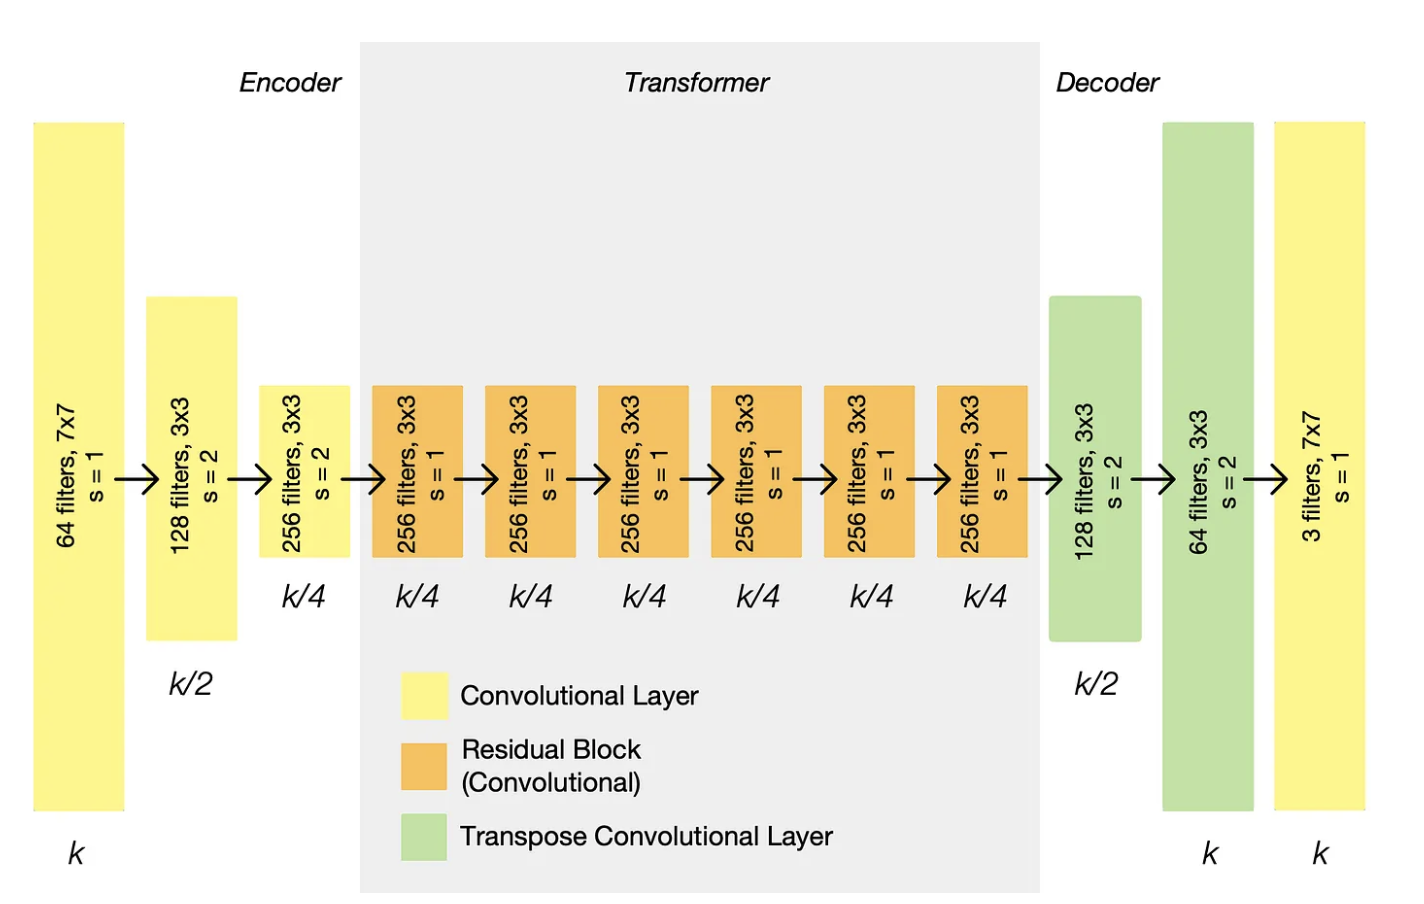


The Generator will consist of 
1. 7x7, 64 filters Conv layer with relu activation 
2. 2 downsampling blocks which will be the encoder part of the image
3. The next 9 proceeding layers will have resblocks wih 3x3, 256 filters conv and a stride of 1
4. The two layer will be upsampling layer which will reduce the channels and increase the height and width of the input to 256 x 256 x 64.
5. The last layer will be a conv layer of 7x7, 3 filters, which will convert it back to a 256 x 256 x 3 RGB image.

**Changes w.r.t. the diagram :** The diagram shows 6 resiudal blocks, which was the architecture for the original paper, instead here I will be using 9 residual block between the Encoder and Decoder.

In [10]:
def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    
    # Feeding the input 
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    
    # Encoder part look at points 1-2 above
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # 2 downsampling blocks
    for _ in range(num_downsampling_blocks):
        # increse filter for each downsample
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # 9 Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # 2 Upsampling blocks
    for _ in range(num_upsample_blocks):
        # Decreasing the filter size in each upsample
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final Conv layer with three filter this will be the output image
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    
    # Tanh activation in the last layer
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### Building Discriminator

Below is a depiction of discriminator architecture, which is also called PatchGAN from [source](https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d). **Note :** I will be uses a slighlty modified version of the architecture depicted in the diagram, the diagram is just for reference, I will describe the changes below.

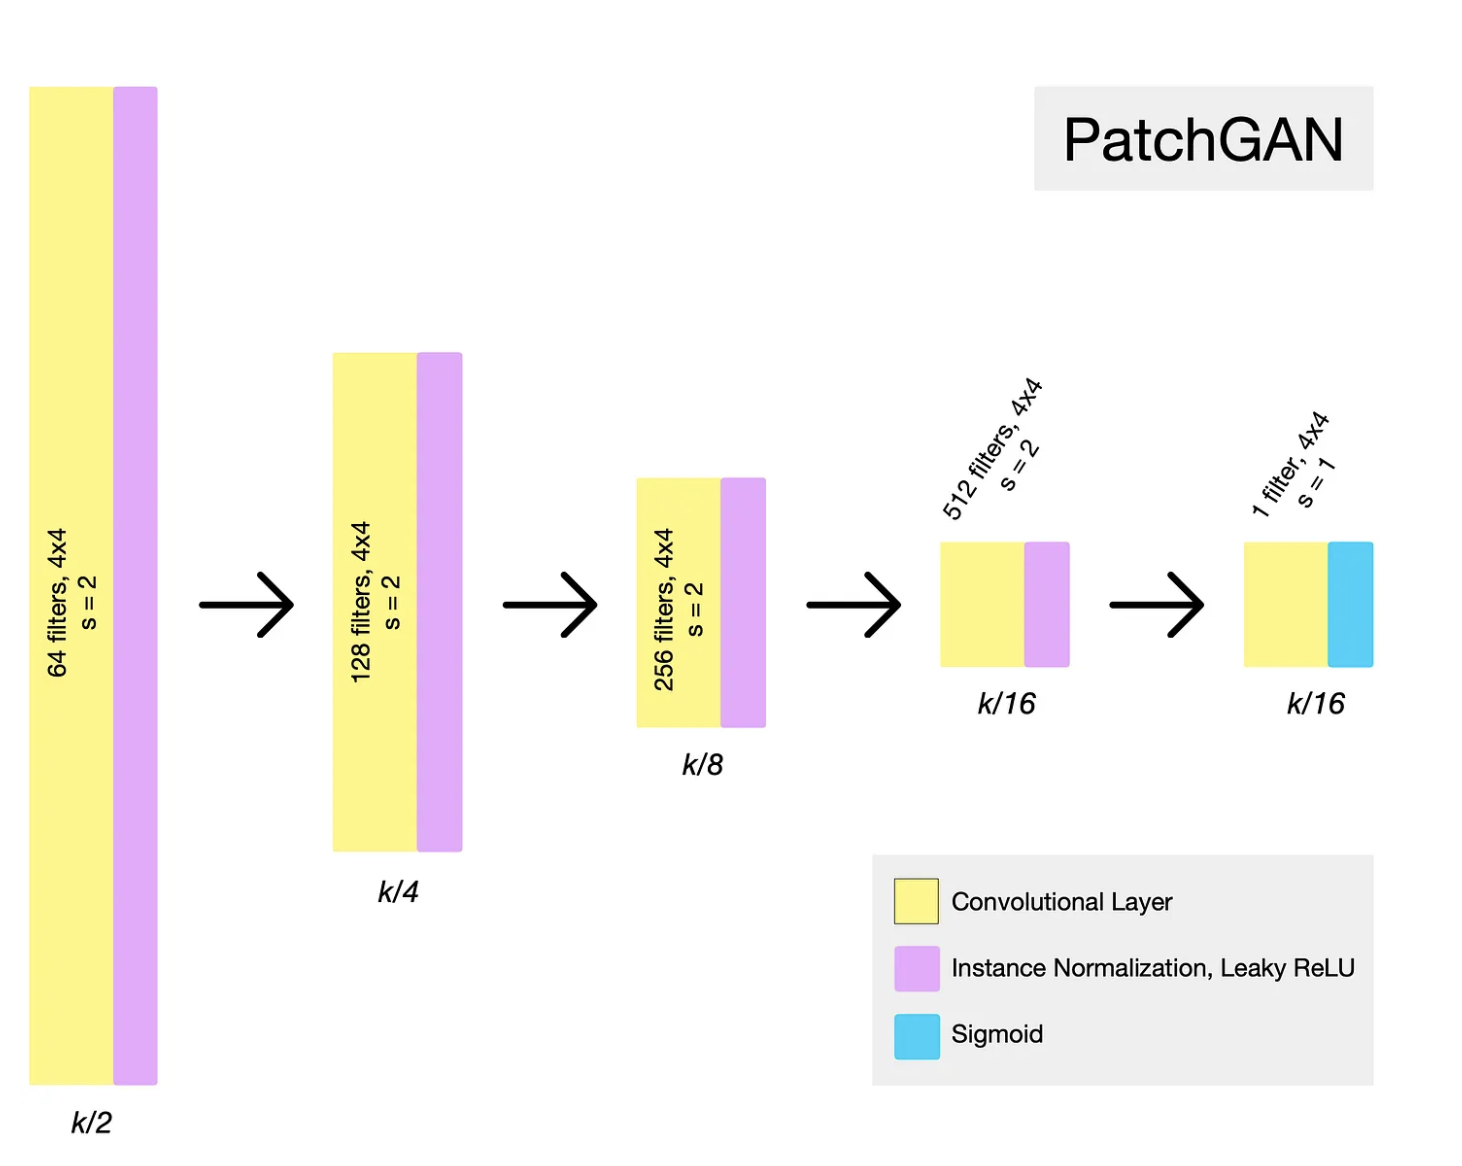

The discriminators job is to indentify an image as fake or real.

The CycleGAN discriminator uses Patch Gan architecture, which consists of the following layers in this implementation:
- **Layer 1** - A 4x4 downsampling block of stride 2, which will ouput a feature map of 128 x 128 x 64.
- **Layer 2-3** - 4x4 downsampling blocks of stride 2, which will ouput a fetuare map after the two convolutions of 32 x 32 x 256
- **Layer 4** - This downsampling block will not half the input but only increase its dimensions to 32 x 32 x 512. 
- **Layer 5** - This layer is 4x4 conv layer with stride 1 with 1 filter, the output of this layer is 32 x 32 x 1, this layer will essentially reduce input to be one dimensional.

**Changes w.r.t. the diagram :** The diagram which shows the PatchGAN architecture used in the original paper, which uses the stride 2 in the 4th layer which generate an ouput of 16 x 16 x 512, in contrast here I use a stride of 1 which will ouput 32 x 32 x 512 feature map. The diagram depicts a sigmoid activation at the 5th layer which I will not be implementing for the 5th layer.

In [11]:
def get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
    
    # Input Image
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    
    # Conv Layer with 64 filters
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(img_input)
    
    # activation
    x = layers.LeakyReLU(0.2)(x)
    
    num_filters = filters
    
    # loop for creating middle three layer these layers will reduce the spatial dimensions by 1/2 and double the filters for each layer
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2))
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1))
    
    # output layer for the discriminator
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

### Creating the generator and discriminator for CycleGAN

In [12]:
# Generator G will generate a monet like painting from the photo, Generator F will do the opposite it will generate original photo from the
# transformed photo

gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Building CycleGAN


This class will define the training algorithm for the GAN, the training algorithm can be defined in terms of the following phases:
1. **Generation Phase:** In this phase we generate images using the Generators three times in the following manner, remeber that Generator 1 which is genG in the code will take a photo and generate a monetesque photo and Generator 2 which is genF in the code will take a monetesque painting and reproduce the original photo. Here first we wil generate a monetesque photo by feeding genG a real photo and name the output fake_y, then we will feed genF a real monet and name the output fake_x. Once this is done we will feed the fake monet painting fake_y to genF which if trained properly should produce the real photo, and feed fake_x to genG which should ideally reproduce the real monet painting. Hence completing the cycle from real photo -> monetesque painting -> fake photo, the job of the GAN is to reproduce the real photo from the monetesque painting and and the monete painting from a fake photo. The last step in generation phase is to pass in the identity photos to the generators, meaning to feed genG a real monet and feed genF a real photo, the expectation from the generators is that it ouputs the same input without change as there is no need for translation.

2. **Discriminate:** Having have finished our generation cycle, it is time to use the Discriminators, we will feed in a real painting to Discriminator Y to classify after that we will provide the genG generated image which is fake_y to classify. In Discriminator X we will try to identify the fake photo from the real ones, here fake monet is fake_x, first we will feed in the real photo to classify then the fake_x to classify. Both the discriminators job is to classify the images as real or fake.

3. **Calculate Generator Loss:** We will train the genF and genG based on the loss occured for not getting classified as real image + the cycle loss  genF and genG produced while reproducing the original input from the fake images + the identity loss which is the loss incurred for not being able to ouput the same input as described above. The loss is stored in the total_loss_G and total_loss_F variables in the code.

4. **Calculate Discriminator Loss:** We calculate discriminator loss based on its lack of capability to identify real as real and generated as fake. The discrimintor loss is stored in the disc_X_loss and disc_Y_loss variables.


5. **Apply Gradient:** The last and final step is to apply the gradient to the Generators and Discriminators using Gradient Tape.


In [13]:
class CycleGan(keras.Model):
    def __init__(self,generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        #self.lambda_identity = lambda_identity

    def compile( self, gen_G_opt, gen_F_opt, disc_X_opt, disc_Y_opt, gen_lf, disc_lf, cycle_lf, identity_lf):
        super().compile()
        self.gen_G_opt = gen_G_opt
        self.gen_F_opt = gen_F_opt
        self.disc_X_opt = disc_X_opt
        self.disc_Y_opt = disc_Y_opt
        self.generator_lf = gen_lf
        self.discriminator_lf = disc_lf
        self.cycle_lf = cycle_lf
        self.identity_lf = identity_lf

    def train_step(self, batch_data):
        # x is Photos and y is Monet
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Photo to fake Monet
            fake_y = self.gen_G(real_x, training=True)
            
            # Monet to fake photo -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle: Photo -> Fake monet -> Fake photo
            cycled_x = self.gen_F(fake_y, training=True)
            
            # Cycle: Monet -> Fake Photo -> Fake monet
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_lf(disc_fake_y)
            gen_F_loss = self.generator_lf(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_lf(real_y, cycled_y, self.lambda_cycle) 
            cycle_loss_F = self.cycle_lf(real_x, cycled_x, self.lambda_cycle)

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + self.identity_lf(real_y, same_y, self.lambda_cycle)
            total_loss_F = gen_F_loss + cycle_loss_F + self.identity_lf(real_x, same_x, self.lambda_cycle)

            # Discriminator loss
            disc_X_loss = self.discriminator_lf(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_lf(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_opt.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_opt.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_opt.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_opt.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

### Defining the loss functions for training

We will use as MeanSquareError to calculate error of the predictions. It is used in the generator_loss function and discriminator_loss function. For identity loss we calculate the Mean Absolute difference between the real and the should be same image and return the error by multiplying it to the lambda coefficient which gives it a weightage. For cycle loss we will calculate the Mean Absolute difference and return the loss weighted by the labmda.


In [14]:
adv_loss_fn = keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    # Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

    # Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

### Defining the Model

I will use Adam optimizers with a very low learning rate of 0.00002, for both the generators and discriminators.

In [29]:
#Create cycle gan model
cycleGan = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycleGan.compile(
    gen_G_opt=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_opt=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_opt=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_opt=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_lf=generator_loss_fn,
    disc_lf=discriminator_loss_fn,
    cycle_lf = calc_cycle_loss,
    identity_lf = identity_loss
)

### Training the model

I will train the model for 60 epochs, 3 train cycles of 20 epoch each 

In [52]:
checkpoint_filepath = "/kaggle/working/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycleGan.fit(
    tf.data.Dataset.zip((train_photo, train_monet)),
    epochs=20,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/20
300/300 [==============================] - 119s 386ms/step - G_loss: 3.0227 - F_loss: 3.6498 - D_X_loss: 0.1568 - D_Y_loss: 0.1979
Epoch 2/20
300/300 [==============================] - 119s 386ms/step - G_loss: 3.0600 - F_loss: 3.6545 - D_X_loss: 0.1554 - D_Y_loss: 0.1937
Epoch 3/20
300/300 [==============================] - 119s 387ms/step - G_loss: 3.0076 - F_loss: 3.6790 - D_X_loss: 0.1554 - D_Y_loss: 0.1952
Epoch 4/20
300/300 [==============================] - 119s 385ms/step - G_loss: 2.9935 - F_loss: 3.7480 - D_X_loss: 0.1468 - D_Y_loss: 0.1906
Epoch 5/20
300/300 [==============================] - 119s 387ms/step - G_loss: 3.0543 - F_loss: 3.7181 - D_X_loss: 0.1564 - D_Y_loss: 0.1759
Epoch 6/20
300/300 [==============================] - 120s 387ms/step - G_loss: 3.0511 - F_loss: 3.6382 - D_X_loss: 0.1541 - D_Y_loss: 0.1840
Epoch 7/20
300/300 [==============================] - 119s 387ms/step - G_loss: 3.0346 - F_loss: 3.6900 - D_X_loss: 0.1504 - D_Y_loss: 0.1692
Epoch 

## Result after training

In [53]:
_, ax = plt.subplots(2, 4, figsize=(12, 12))
photo_iter = iter(train_photo)
test_photo = [next(photo_iter) for _ in range(20)]

for i, img in enumerate(test_photo[10:14]):
    prediction = cycleGan.gen_G(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input image")
    ax[1, i].set_title("Translated image")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.tight_layout()

plt.show()

## Submission Score of 0.52



## Submission file

In [41]:
import PIL
import os 

# creating the imges directory
output_dir = "/kaggle/images/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for img in train_photo:
    prediction = cycleGan.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/images/" + str(i) + ".jpg")
    i += 1
print("Generation over!")

In [42]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'